In [470]:
# array manipulation
import numpy as np

# random distribution
from scipy.stats import poisson

# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# supervised learning
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# used to make copies of the regression model
from copy import deepcopy

## Experiment paremeters

In [450]:
np.random.seed(123) # set random seed to replicate experiments

x_0 = 10  # initial inventory

lambda1 = 2 # intensity of counter-party order arrival for exchange 1 
lambda2 = 1 # intensity of counter-party order arrival for exchange 2 

r1 = .001 # rebate for exchange 1
r2 = .002 # rebate for exchange 2

beta = .0003 # trader's risk aversion or impatience level
epsilon = 1e-10 # tolerance to consider convergence of the algorithms

n_simuls = 5000 # number of transitions simulated for fitted Q-iteration

# Value Iteration

In [451]:

# distribution of the number of share filled for one exchange
def prob_y(y, x, lbda):
    
    
    if y > x:
        
        return 0
    
    if y > 0:
        
        p = poisson.pmf(x-y, lbda)
        
    else:
        
        p = 1 - poisson.cdf(x-1, lbda)
        
    return p


# cost given initial quantity routed to two exchanges and unfilled quantities resulting
def g(y1, y2, x1, x2, r1, r2, beta):


    return np.maximum((x1 - y1),0)*(1-r1) + np.maximum((x2 - y2),0)*(1-r2) + beta*(y1 + y2)

### Algorithm

In [453]:

J = np.ones(x_0+1) # store expected future costs for each state
new_J = J.copy()

while True:

    Q = []

    for j in range(len(J)): # for each state

        E_u = []
        x = j

        for u in range(int(x+1)): # for each action

            exp_val_u = 0

            x1 = u
            x2 = x-u

            for y1 in range(x1+1):

                for y2 in range(x2+1):


                        # joint probability of ending with y1 and y2 unfilled quantities on each exchange
                        p_y1_y2 = prob_y(y1, x1, lambda1) * prob_y(y2, x2, lambda2)

                        g_y1_y2 = g(y1, y2, x1, x2, r1, r2, beta)

                        # next state
                        y = y1 + y2
                        
                        # add contribution to expected value
                        exp_val_u += p_y1_y2 * (g_y1_y2 + (J[y] if y>0 else 0))


            E_u.append(exp_val_u)


        new_J[j] = np.min(E_u)

        Q.append(E_u)
    
    if np.max(np.abs(J-new_J)) > epsilon:
        J = new_J.copy()
    else:
        break


In [455]:
np.max(np.abs(J-new_J)) # check convergence

5.496758603840135e-11

# Fitted-Q Iteration

In [456]:
# simulate one transition given state x and control u
def simul(x, u, lambda1, lambda2, r1, r2, beta):
    
    x1 = u
    x2 = x-u
    
    w1 = poisson.rvs(lambda1)
    w2 = poisson.rvs(lambda2)
    
    y1 = max(x1-w1, 0)
    y2 = max(x2-w2, 0)
    
    cost = g(y1, y2, x1, x2, r1, r2, beta)
        
    x_next = y1 + y2
    
    return (x, u, cost, x_next)

In [457]:
# create pairs of (x_next, u) for each possible action u in state x_next
def make_examples(x_next):
    
    examples = []
    for x in x_next:
        
        x_examples = []
        
        for u in range(x+1):
            x_examples.append((x,u))
            
        examples.append(np.array(x_examples))
    
    return examples


# use polynomial regression to evaluate next best action for each x_next 
def eval_Q_next_max(examples, lr, poly):
    
    
    splits = np.cumsum([len(e) for e in examples])[:-1]
    
    
    stacked_examples = np.vstack(examples)
    
    Q = lr.predict(poly.transform(stacked_examples))
    Q = np.split(Q, splits)
    
    
    Q_next_max = [np.max(q) if examples[i][0][0]!=0 else 0 for i, q in enumerate(Q)]

    return np.vstack(Q_next_max)

### Algorithm

In [458]:
# used to generate polynomial features
poly = PolynomialFeatures()
poly.fit(np.zeros((1, 2)))


# Linear regression on the polynomial features initialized to predict zeros
lr = LinearRegression()
lr.fit(poly.transform(np.zeros((1, 2))), np.zeros((1, 1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [461]:
# create list of all possible state-control pairs to sample from
state_controls = []
for i in range(1, x_0+1):
    for j in range(i+1):
        state_controls.append((i,j))

        
# generate n_simuls random transitions

simuls = []

for _ in range(n_simuls):
    
    idx = np.random.randint(len(state_controls))
    i, j = state_controls[idx]
    simuls.append(simul(i, j, lambda1, lambda2, r1, r2, beta))
    

# split state, control, cost, and next state into different arrays
x, u, costs, x_next = np.split(np.vstack(simuls), 4, axis=1)

# generate polynomial features once for all transitions
features = poly.transform(np.hstack([x,u]))


# generate next_state-control pairs once for all transitions
x_next_u = make_examples(x_next.flatten().astype(int))


In [465]:
lr_last = deepcopy(lr) 

while True:
    
    # create new targets
    Q_next_max = eval_Q_next_max(x_next_u, lr_last, poly)
    targets = costs + Q_next_max

    # fit on new targets
    features = poly.transform(np.hstack([x,u]))
    lr.fit(features, targets)

    # stop if predicted Q-factors do not improve
    if np.max(np.abs(lr.predict(features) - lr_last.predict(features)))>epsilon:
        lr_last = deepcopy(lr) 
    else:
        break     

In [466]:
np.max(np.abs(lr.predict(features) - lr_last.predict(features)))

4.178701829005149e-11

# Plotting

The following cells are only used to generate plots and are thus left uncommented

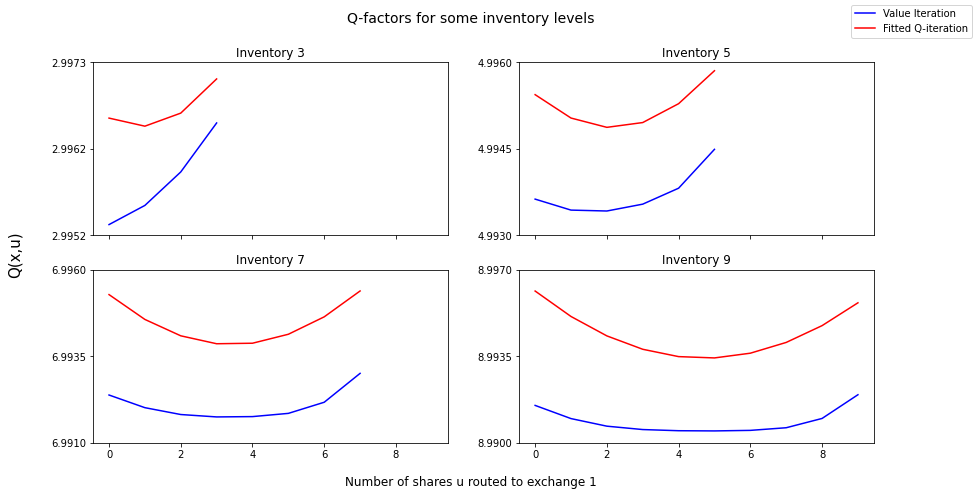

In [467]:

rows = 2
cols = 2
gap = x_0 // (rows*cols)


fig, axes = plt.subplots(rows,cols, sharex=True)

fig.set_size_inches((14,7))


for i, to_buy in enumerate(list(range(1, x_0, gap))[-rows*cols:]):
    
    features = []

    for control in range(to_buy+1):
        features.append((to_buy, control))
        
    features = poly.transform(np.vstack(features))
    
    q_approx = lr.predict(features)
    q_exact = Q[to_buy]
    
    r = i // cols
    c = i % cols
    
    axes[r][c].plot(q_exact, label="Value Iteration" if i==0 else "", color='blue')
    axes[r][c].plot(q_approx, label="Fitted Q-iteration" if i==0 else "", color='red')
    axes[r][c].set_title(f"Inventory {to_buy}")
    axes[r][c].yaxis.set_major_formatter(StrMethodFormatter('{x:,.4f}'))
    yticks = axes[r,c].get_yticks()
    axes[r,c].set_yticks([yticks[0], np.median(yticks), yticks[-1]])

    
fig.text(0.5, 0.04, 'Number of shares u routed to exchange 1', ha='center', size=12)
fig.text(0.04, 0.5, 'Q(x,u)', va='center', rotation='vertical', size=15)
fig.suptitle("Q-factors for some inventory levels", size=14)
fig.legend()

In [468]:

mu_approx = []

for i, to_buy in enumerate(range(1,x_0+1)):
    
    features = []

    for control in range(to_buy+1):
        features.append((to_buy, control))
        
    features = poly.transform(np.vstack(features))
    
    q_approx = lr.predict(features).argmin()
    
    mu_approx.append(q_approx)
    
    
mu_exact = [np.argmin(q_exact) for q_exact in Q[1:]]


Text(0.04, 0.5, 'Number of shares (control)')

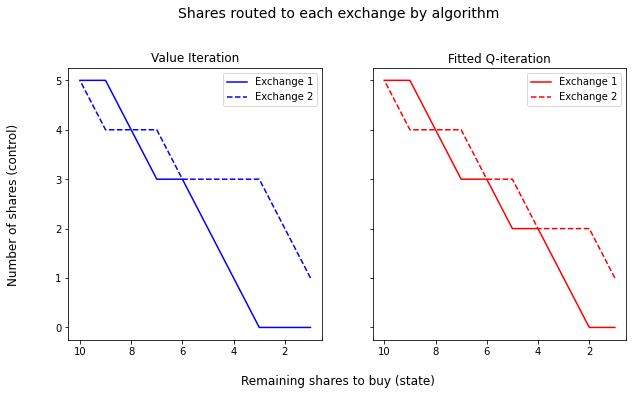

In [469]:

x_ticks = np.array(list(range(1,x_0+1)))
fig, axes = plt.subplots(1,2, sharex=True, sharey=True)
fig.set_size_inches((10,5))

axes[0].plot(x_ticks, mu_exact, color='blue', label="Exchange 1")
axes[0].plot(x_ticks, x_ticks - np.array(mu_exact), '--', color='blue', label="Exchange 2")
axes[0].legend()
axes[0].set_title("Value Iteration")
axes[0].invert_xaxis()

axes[1].plot(x_ticks, mu_approx, color='red', label="Exchange 1")
axes[1].plot(x_ticks, x_ticks - np.array(mu_approx), '--', color='red', label="Exchange 2")
axes[1].legend()
axes[1].set_title("Fitted Q-iteration")


fig.suptitle("Shares routed to each exchange by algorithm", y=1.05, size=14)
fig.text(0.5, 0.0, 'Remaining shares to buy (state)', ha='center', size=12)
fig.text(0.04, 0.5, 'Number of shares (control)', va='center', rotation='vertical', size=12)